# 🌴The Data of Dates: Ajwa or Medjool?🌴
# VGG-16 version

Simon Smith's final project for CS 4710, modified from final project for CS 4700

Thanks to Dr. Ghassan Bati of Umm Al-Qura University in Saudi Arabia for the dataset. I only *barely* manually adjusted some of the images - changing the orientation of 2 or 3 horizonal Ajwa images to vertical so that they would match the rest of the dataset.
  https://www.qscience.com/content/journals/10.5339/jist.2023.12

Thanks to Dr. Chen for her help with this project last semester, and to Larry for his help this semester!

# Setup Instructions
In your Google Drive, upload the provided folder **date_data** (attached in submission)

In [1]:
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("/content/drive/My Drive/date_data")

Mounted at /content/drive


# Subsets, Transforms, Load data
Define subsets (train, validation, test)
Perform transforms (resizing for all; data augmentation for train)
Load data

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision import transforms

# Step 1: Load without any transform initially
full_dataset = ImageFolder('./ajwa_medjool_database/') # ('./test_image/')

# Step 2: Split into subsets
train_size = int(0.65 * len(full_dataset))
valid_size = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - valid_size

train_subset, valid_subset, test_subset = random_split(full_dataset, [train_size, valid_size, test_size])

# Step 3: Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)), # Change image size for VGG-16 expected size
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), # Change image size for VGG-16 expected size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Step 4: Assign transforms by wrapping in Subset objects again
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

# Step 5: Wrap each subset
train_dataset = TransformedDataset(train_subset, train_transform)
valid_dataset = TransformedDataset(valid_subset, test_transform)
test_dataset  = TransformedDataset(test_subset, test_transform)

# Step 6: load data
train_dat_load = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dat_load = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dat_load  = DataLoader( test_dataset, batch_size=32, shuffle=False)


#Visualize data (optional)
Compare the augmented training data against non-augmented test data


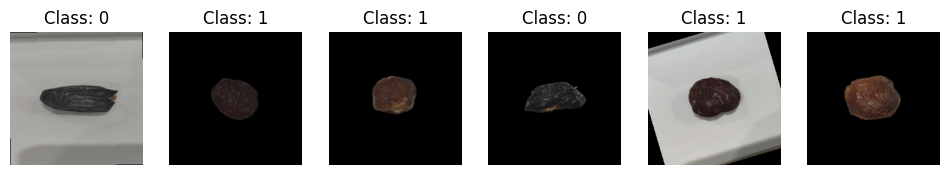

In [3]:
# visualize augmented images in training dataset
images, labels = next(iter(train_dat_load))

fig, axes = plt.subplots(1, 6, figsize=(12,6))
for i in range(6):
  img = images[i] * 0.5 + 0.5  # unnormalize
  img = img.permute(1, 2, 0).clip(0,1)
  axes[i].imshow(img)
  axes[i].set_title(f"Class: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

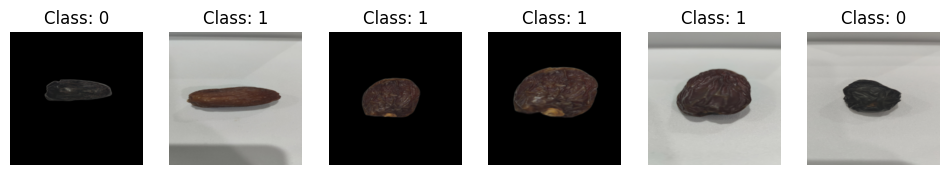

In [4]:
# show non-augmented images in test dataset
images, labels = next(iter(test_dat_load))

fig, axes = plt.subplots(1, 6, figsize=(12,6))
for i in range(6):
  img = images[i] * 0.5 + 0.5  # unnormalize
  img = img.permute(1, 2, 0).clip(0,1)
  axes[i].imshow(img)
  axes[i].set_title(f"Class: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

#Pre-trained VGG-16 model


In [5]:
# The VGG-16 model, defined by the code below:
model = models.vgg16(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 2)  # Two classes: Ajwa and Medjool
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 125MB/s]


In [6]:
#Loss and Optimizer

# Cross Entropy loss
loss_fn = nn.CrossEntropyLoss()
# Adam optimizer - Changed learning rate for VGG-16 from 0.001 -> 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train Model

In [7]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs

  for epoch in range(num_epochs):
    model.train()

    for x_batch, y_batch in train_dl:
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)

      is_correct = (
        torch.argmax(pred, dim=1) == y_batch
      ).float()

      accuracy_hist_train[epoch] += is_correct.sum()

    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()

    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

        is_correct = (
            torch.argmax(pred, dim=1) == y_batch
        ).float()

        accuracy_hist_valid[epoch] += is_correct.sum()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val _accuracy: '
          f'{accuracy_hist_valid[epoch]:.4f}')

  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



In [11]:
from time import time

torch.manual_seed(1)
num_epochs = 1
model_start_time = time()
hist = train(model, num_epochs, train_dat_load, valid_dat_load)

# Save as pickle, in case runtime disconnects
with open('./training_pickle/train_results_ML2_VGG-16.pkl', 'wb') as f:
    pickle.dump((hist), f)

training_time = time() - model_start_time
print(f'Training time: {int(training_time / 60)} min, {int(training_time%60)} sec')


Epoch 1 accuracy: 1.0000 val _accuracy: 0.9333
Training time: 6 min, 8 sec


#Visualise Learning Curves



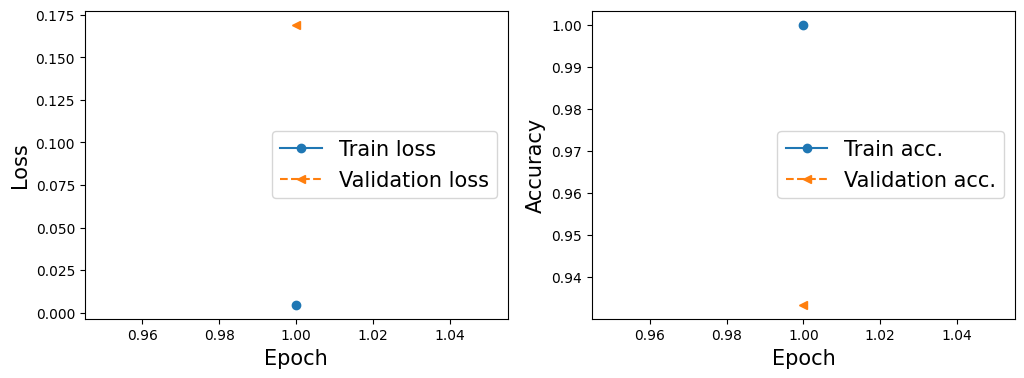

In [12]:
# Load pickle
with open('./training_pickle/train_results_ML2_VGG-16.pkl', 'rb') as f:
    hist = pickle.load(f)


import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

#Evaluate Model on Test Data


In [15]:
for images, labels in test_dat_load:
  images = images / 225. #normalize
  pred = model(images) #predict
  print(pred.shape)

torch.Size([32, 2])
torch.Size([8, 2])


In [13]:
# check num correct:
all_predicts = []
all_labels = []

for images, labels in test_dat_load:
  pred = model(images)
  all_predicts.append(torch.argmax(pred, dim=1))
  all_labels.append(labels)

all_predicts = torch.cat(all_predicts)
all_labels = torch.cat(all_labels)

is_correct = (all_predicts == all_labels).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9750


#Visualisation of model predictions of test data


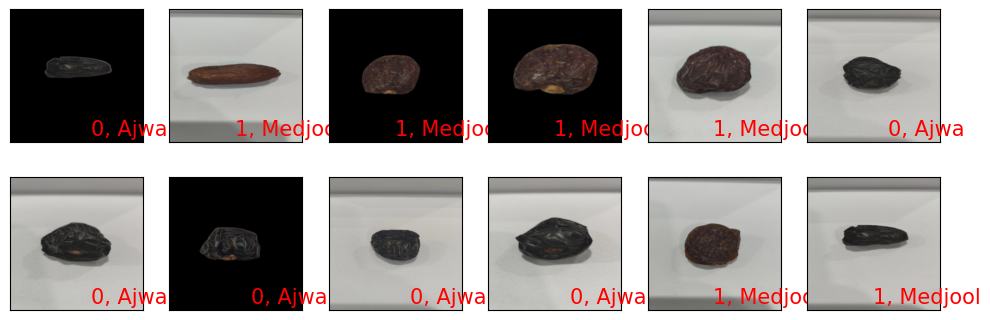

In [14]:
fit = plt.figure(figsize=(12,4))

for i in range(12):
  ax = fit.add_subplot(2,6,i+1)
  ax.set_xticks([]); ax.set_yticks([])

  img = test_dataset[i][0]

  pred = model(img.unsqueeze(0))
  y_pred = torch.argmax(pred)

  ###
  img_denorm = img * torch.tensor([0.5, 0.5, 0.5]).view(3,1,1) + torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
  ax.imshow(img_denorm.permute(1,2,0).clip(0,1))
  #ax.imshow(img.permute(1,2,0).clip(0,1))

  ax.text(0.9, 0.1, str(y_pred.item()) + ', ' + ['Medjool' if y_pred.item() else 'Ajwa'][0],
          size=15, color='red',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)
plt.show()